In [1]:
import matplotlib as plt
plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') # 폰트 적용

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/03_income_predict/data/"

In [3]:
import numpy as np
import pandas as pd

train = pd.read_csv(f"{DATA_PATH}train_data_2.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}test_data_2.csv") # 테스트 데이터

# train = pd.read_csv(f"{DATA_PATH}train_data.csv")
# test = pd.read_csv(f'{DATA_PATH}test_data.csv')

train.shape, test.shape

((20000, 23), (10000, 22))

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# 연속형 변수 추출
train_int = train[train.describe().columns].copy()
# 이산형 변수 추출, 연속형 변수가 아닌 부분을 train.columns.difference를 통해서 출력해주는 것이다.
train_str = train[train.columns.difference(train.describe().columns)].copy()

# Feature Engineering

In [6]:
train_int.describe()

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Income
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,35.632500,34.943050,383.129500,40.202150,123.451450,554.565250
std,17.994414,22.254592,4144.247487,279.182677,1206.949429,701.553155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,52.000000,0.000000,0.000000,0.000000,500.000000
75%,47.000000,52.000000,0.000000,0.000000,0.000000,875.000000
max,90.000000,52.000000,99999.000000,4356.000000,45000.000000,9999.000000


- HouseHold summary X
- Hispanic_Origin이 Do not know와 NA,Chicano는 삭제
- 성능이 안나오면 Hispanic_Origin은 삭제
- Occupation_Status 'Armed Force'삭제
- Industry_Status에서 'Children'만 따로 뽑아준다.
- Employment_Status에서 18세 미만의 경우에는 children, 그렇지 않으면 Armed Force로 분류한다.
- 이진분류
    - Gender
    - Income_Status
    - Martial Status

In [6]:
train['Hispanic_Origin'] = train['Hispanic_Origin'].str.strip()

In [7]:
# Hispanic_Origin이 Do not know와 NA,Chicano는 삭제
train = train[~(train['Hispanic_Origin'] == 'NA') & ~(train['Hispanic_Origin'] == 'Do not konw') & ~(train['Hispanic_Origin'] == 'Chicano')].reset_index(drop = True).copy()

train.shape

(19914, 23)

In [8]:
# train.drop(columns = ['Hispanic_Origin'],inplace = True)
# test.drop(columns = ['Hispanic_Origin'],inplace = True)

# train.shape,test.shape

In [9]:
# Occupation_Status 'Armed Force'삭제

train[~(train['Occupation_Status'] == 'Armed Force')].shape

(19914, 23)

In [10]:
train_str['Gender'].value_counts()

F    10472
M     9528
Name: Gender, dtype: int64

In [11]:
# Industry_Status에서 'Children'만 따로 뽑아준다.

mask = (train['Industry_Status'] == 'Not in universe or children') & (train['Age'] < 18)

# 선택된 행의 'Industry_Status' 값을 'Children'로 변경
train.loc[mask, 'Industry_Status'] = 'Children'

# 그 외의 것들은 Not in universe로 변경해준다.
mask = (train['Industry_Status'] == 'Not in universe or children')

# 선택된 행의 'Industry_Status' 값을 'Not in universe'로 변경
train.loc[mask, 'Industry_Status'] = 'Not in universe'

train.shape

(19914, 23)

In [12]:
# Industry_Status에서 'Children'만 따로 뽑아준다. (test)

mask = (test['Industry_Status'] == 'Not in universe or children') & (test['Age'] < 18)

# 선택된 행의 'Industry_Status' 값을 'Children'로 변경
test.loc[mask, 'Industry_Status'] = 'Children'

# 그 외의 것들은 Not in universe로 변경해준다.
mask = (test['Industry_Status'] == 'Not in universe or children')

# 선택된 행의 'Industry_Status' 값을 'Not in universe'로 변경
test.loc[mask, 'Industry_Status'] = 'Not in universe'

test.shape

(10000, 22)

In [13]:
# Employment_Status에서 18세 미만의 경우에는 children, 그렇지 않으면 Armed Force로 분류한다.

mask = (train['Employment_Status'] == 'Children or Armed Forces') & (train['Age'] < 18)

# 선택된 행의 'Employment_Status' 값을 'Children or Armed Forces'로 변경
train.loc[mask, 'Employment_Status'] = 'Children'

# 그 외의 것들은 Armed Forces로 변경해준다.
mask = (train['Employment_Status'] == 'Children or Armed Forces')

# 선택된 행의 'Employment_Status' 값을 'Armed Forcese'로 변경
train.loc[mask, 'Employment_Status'] = 'Armed Forces'

train['Employment_Status'].value_counts()

Armed Forces                     8538
Full-Time                        6563
Children                         2554
Not Working                      1211
Choice Part-Time                  593
Part-Time (Usually Part-Time)     158
Seeking Full-Time                 121
Part-Time (Usually Full-Time)      99
Seeking Part-Time                  77
Name: Employment_Status, dtype: int64

In [14]:
# Employment_Status에서 18세 미만의 경우에는 children, 그렇지 않으면 Armed Force로 분류한다.

mask = (test['Employment_Status'] == 'Children or Armed Forces') & (test['Age'] < 18)

# 선택된 행의 'Employment_Status' 값을 'Children or Armed Forces'로 변경
test.loc[mask, 'Employment_Status'] = 'Children'

# 그 외의 것들은 Armed Forces로 변경해준다.
mask = (test['Employment_Status'] == 'Children or Armed Forces')

# 선택된 행의 'Employment_Status' 값을 'Armed Forcese'로 변경
test.loc[mask, 'Employment_Status'] = 'Armed Forces'

test['Employment_Status'].value_counts()

Armed Forces                     4329
Full-Time                        3269
Children                         1237
Not Working                       627
Choice Part-Time                  293
Part-Time (Usually Part-Time)      88
Part-Time (Usually Full-Time)      62
Seeking Full-Time                  59
Seeking Part-Time                  36
Name: Employment_Status, dtype: int64

In [15]:
train['Martial_Status'].value_counts()

Married                         9518
Single                          7347
Divorced                        1627
Widowed                          752
Separated                        432
Married (Spouse Absent)          169
Married (Armed Force Spouse)      69
Name: Martial_Status, dtype: int64

In [16]:
train.replace(['Married','Single','Divorced','Widowed','Separated',
               'Married (Spouse Absent)','Married (Armed Force Spouse)'],
              ['marry','no marry','no marry','no marry','no marry',
               'marry','marry'],inplace = True)

In [17]:
train['Martial_Status'].value_counts()

no marry    10158
marry        9756
Name: Martial_Status, dtype: int64

In [18]:
# Gender, Income_Status, Martial_Status

train['Gender'] = np.where(train['Gender'] == 'M', 1, 0)
test['Gender'] = np.where(test['Gender'] == 'M', 1, 0)

train['Gender'].value_counts()

0    10426
1     9488
Name: Gender, dtype: int64

In [19]:
train['Income_Status'] = np.where(train['Income_Status'] == 'Under Median', 1, 0)
test['Income_Status'] = np.where(test['Income_Status'] == 'Under Median', 1, 0)

train['Income_Status'].value_counts()

1    19025
0      889
Name: Income_Status, dtype: int64

In [20]:
train['Martial_Status'] = np.where(train['Martial_Status'] == 'marry', 1, 0)
test['Martial_Status'] = np.where(test['Martial_Status'] == 'marry', 1, 0)

train['Martial_Status'].value_counts()

0    10158
1     9756
Name: Martial_Status, dtype: int64

# Feature 추가

In [21]:
# Age_Working

train['Age_Working'] = train['Age'] * (train['Working_Week (Yearly)'].replace(0,1))
test['Age_Working'] = test['Age'] * (test['Working_Week (Yearly)'].replace(0,1))

train.shape,test.shape

((19914, 24), (10000, 23))

In [22]:
# Age_per_Working

train['Age_per_Working'] = train['Age'] / (train['Working_Week (Yearly)'].replace(0,1))
test['Age_per_Working'] = test['Age'] / (test['Working_Week (Yearly)'].replace(0,1))

train.shape, test.shape

((19914, 25), (10000, 24))

In [23]:
# Total_amount

train['Total_amount'] = train['Gains'] + train['Losses'] + train['Dividends']
test['Total_amount'] = test['Gains'] + test['Losses'] + test['Dividends']

train.shape , test.shape

((19914, 26), (10000, 25))

In [24]:
# Total_amount_per_Working_Week

train['Total_amount_per_Working_Week'] = train['Total_amount'] / (train['Working_Week (Yearly)'].replace(0,1))
test['Total_amount_per_Working_Week'] = test['Total_amount'] / (test['Working_Week (Yearly)'].replace(0,1))

train.shape,test.shape

((19914, 27), (10000, 26))

In [25]:
# Total_amount_times_Working_Week

train['Total_amount_times_Working_Week'] = train['Total_amount'] * (train['Working_Week (Yearly)'].replace(0,1))
test['Total_amount_times_Working_Week'] = test['Total_amount'] * (test['Working_Week (Yearly)'].replace(0,1))

train.shape,test.shape

((19914, 28), (10000, 27))

In [26]:
# Total_amount_per_Age

train['Total_amount_per_Age'] = train['Total_amount'] / train['Age']
test['Total_amount_per_Age'] = test['Total_amount'] / test['Age']

train.shape,test.shape

((19914, 29), (10000, 28))

In [27]:
# Total_amount_times_Age

train['Total_amount_times_Age'] = train['Total_amount'] * train['Age']
test['Total_amount_times_Age'] = test['Total_amount'] * test['Age']

train.shape,test.shape

((19914, 30), (10000, 29))

In [28]:
# Gains_per_Working_Week

train['Gains_per_Working_Week'] = train['Gains'] / (train['Working_Week (Yearly)'].replace(0,1))
test['Gains_per_Working_Week'] = test['Gains'] / (test['Working_Week (Yearly)'].replace(0,1))

train.shape,test.shape

((19914, 31), (10000, 30))

In [29]:
# Gains_times_Working_Week

train['Gains_times_Working_Week'] = train['Gains'] * (train['Working_Week (Yearly)'].replace(0,1))
test['Gains_times_Working_Week'] = test['Gains'] * (test['Working_Week (Yearly)'].replace(0,1))

train.shape,test.shape

((19914, 32), (10000, 31))

In [30]:
# Gains_per_Age

train['Gains_per_Age'] = train['Gains'] / train['Age']
test['Gains_per_Age'] = test['Gains'] / test['Age']

train.shape,test.shape

((19914, 33), (10000, 32))

In [31]:
# Gains_times_Age

train['Gains_times_Age'] = train['Gains'] * train['Age']
test['Gains_times_Age'] = test['Gains'] * test['Age']

train.shape,test.shape

((19914, 34), (10000, 33))

In [32]:
# Losses_per_Working_Week

train['Losses_per_Working_Week'] = train['Losses'] / (train['Working_Week (Yearly)'].replace(0,1))
test['Losses_per_Working_Week'] = test['Losses'] / (test['Working_Week (Yearly)'].replace(0,1))

train.shape,test.shape

((19914, 35), (10000, 34))

In [33]:
# Losses_times_Working_Week

train['Losses_times_Working_Week'] = train['Losses'] * (train['Working_Week (Yearly)'].replace(0,1))
test['Losses_times_Working_Week'] = test['Losses'] * (test['Working_Week (Yearly)'].replace(0,1))

train.shape,test.shape

((19914, 36), (10000, 35))

In [34]:
# Losses_per_Age, Losses_times_Age

train['Losses_per_Age'] = train['Losses'] / train['Age']
test['Losses_per_Age'] = test['Losses'] / test['Age']

train['Losses_times_Age'] = train['Losses'] * train['Age']
test['Losses_times_Age'] = test['Losses'] * test['Age']

train.shape,test.shape

((19914, 38), (10000, 37))

In [35]:
# Dividends_per_Working_Week, Dividends_times_Working_Week

train['Dividends_per_Working_Week'] = train['Dividends'] / (train['Working_Week (Yearly)'].replace(0,1))
test['Dividends_per_Working_Week'] = test['Dividends'] / (test['Working_Week (Yearly)'].replace(0,1))

train['Dividends_times_Working_Week'] = train['Dividends'] * (train['Working_Week (Yearly)'].replace(0,1))
test['Dividends_times_Working_Week'] = test['Dividends'] * (test['Working_Week (Yearly)'].replace(0,1))

train.shape, test.shape

((19914, 40), (10000, 39))

In [36]:
# Dividends_per_Age, Dividends_times_Age

train['Dividends_per_Age'] = train['Dividends'] / train['Age']
test['Dividends_per_Age'] = test['Dividends'] / test['Age']

train['Dividends_times_Age'] = train['Dividends'] * train['Age']
test['Dividends_times_Age'] = test['Dividends'] * test['Age']

train.shape, test.shape

((19914, 42), (10000, 41))

# pivot table
- pivot table을 추가시켰을 때와 제외시켰을 때 점수 차이가 1점 정도 차이가 나는 것을 확인! pivot table을 추가시켜 모델의 성능을 높힌다.

## Age, Working Week의 Income에 따른 Pivot table

In [37]:
# Age, Working Week의 Income에 따른 Pivot table을 만들고 concat

tmp = train.pivot_table(index = ['Age'],
                                columns = ['Working_Week (Yearly)'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Age' for t in tmp.columns]
tmp.rename(columns = {'Age__Age':'Age'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Age')
test = pd.merge(test,tmp,how = 'left',on = 'Age')

train.shape,test.shape

((19914, 95), (10000, 94))

## Household_Status와 Martial_Status를 이용한 pivot table

In [38]:
# Household_Status와 Martial_Status를 이용한 pivot table
# 수입의 평균

tmp = train.pivot_table(index = ['Household_Status'],
                                columns = ['Martial_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Status' for t in tmp.columns]
tmp.rename(columns = {'Household_Status__Household_Status':'Household_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Status')

train.shape,test.shape

((19914, 97), (10000, 96))

In [39]:
# Household_Status와 Martial_Status를 이용한 pivot table
# 나이의 평균

tmp = train.pivot_table(index = ['Household_Status'],
                                columns = ['Martial_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Household_Status__Household_Status_2':'Household_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Status')

train.shape,test.shape

((19914, 99), (10000, 98))

In [40]:
# Household_Status와 Martial_Status를 이용한 pivot table
# Working_Week (Yearly)의 평균

tmp = train.pivot_table(index = ['Household_Status'],
                                columns = ['Martial_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Household_Status__Household_Status_3':'Household_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Status')

train.shape,test.shape

((19914, 101), (10000, 100))

In [41]:
# Household_Status와 Martial_Status를 이용한 pivot table
# Working_Week (Yearly)의 평균

tmp = train.pivot_table(index = ['Household_Status'],
                                columns = ['Martial_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Household_Status__Household_Status_4':'Household_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Status')

train.shape,test.shape

((19914, 103), (10000, 102))

## Occupation_Status & Martial_Status의 pivot table

In [42]:
# Occupation_Status & Martial_Status
# 수입 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Martial_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 105), (10000, 104))

In [43]:
# Occupation_Status & Martial_Status
# Working_Week의 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Martial_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_2':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 107), (10000, 106))

In [44]:
# Occupation_Status & Martial_Status
# Age의 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Martial_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_3':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 109), (10000, 108))

In [45]:
# Occupation_Status & Martial_Status
# Age_Working의 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Martial_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_4':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 111), (10000, 110))

## Tax_Status와 Marital_Status를 이용한 pivot table 구성

In [46]:
# Tax_Status와 Marital_Status
# 수입 평균

tmp = train.pivot_table(index = ['Tax_Status'],
                                columns = ['Martial_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Tax_Status' for t in tmp.columns]
tmp.rename(columns = {'Tax_Status__Tax_Status':'Tax_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Tax_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Tax_Status')

train.shape,test.shape

((19914, 113), (10000, 112))

In [47]:
# Tax_Status와 Marital_Status
# Working_Week의 평균

tmp = train.pivot_table(index = ['Tax_Status'],
                                columns = ['Martial_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Tax_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Tax_Status__Tax_Status_2':'Tax_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Tax_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Tax_Status')

train.shape,test.shape

((19914, 115), (10000, 114))

In [48]:
# Tax_Status와 Marital_Status
# Age의 평균

tmp = train.pivot_table(index = ['Tax_Status'],
                                columns = ['Martial_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Tax_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Tax_Status__Tax_Status_3':'Tax_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Tax_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Tax_Status')

train.shape,test.shape

((19914, 117), (10000, 116))

In [49]:
# Tax_Status와 Marital_Status
# Age_Working의 평균

tmp = train.pivot_table(index = ['Tax_Status'],
                                columns = ['Martial_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Tax_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Tax_Status__Tax_Status_4':'Tax_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Tax_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Tax_Status')

train.shape,test.shape

((19914, 119), (10000, 118))

## HouseHold_Summary와 Martial_Status의 pivot table

In [50]:
# HouseHold_Summary와 Marital_Status
# 수입 평균

tmp = train.pivot_table(index = ['Household_Summary'],
                                columns = ['Martial_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Summary' for t in tmp.columns]
tmp.rename(columns = {'Household_Summary__Household_Summary':'Household_Summary'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Summary')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Summary')

train.shape,test.shape

((19914, 121), (10000, 120))

In [51]:
# HouseHold_Summary와 Marital_Status
# Age 평균

tmp = train.pivot_table(index = ['Household_Summary'],
                                columns = ['Martial_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Summary_2' for t in tmp.columns]
tmp.rename(columns = {'Household_Summary__Household_Summary_2':'Household_Summary'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Summary')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Summary')

train.shape,test.shape

((19914, 123), (10000, 122))

In [52]:
# HouseHold_Summary와 Marital_Status
# Working_Week (Yearly) 평균

tmp = train.pivot_table(index = ['Household_Summary'],
                                columns = ['Martial_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Summary_3' for t in tmp.columns]
tmp.rename(columns = {'Household_Summary__Household_Summary_3':'Household_Summary'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Summary')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Summary')

train.shape,test.shape

((19914, 125), (10000, 124))

In [53]:
# HouseHold_Summary와 Marital_Status
# Age_Working 평균

tmp = train.pivot_table(index = ['Household_Summary'],
                                columns = ['Martial_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Household_Summary_4' for t in tmp.columns]
tmp.rename(columns = {'Household_Summary__Household_Summary_4':'Household_Summary'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Household_Summary')
test = pd.merge(test,tmp,how = 'left',on = 'Household_Summary')

train.shape,test.shape

((19914, 127), (10000, 126))

## Occupation_Status와 Martial_Status의 pivot table

In [54]:
# 수입 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 158), (10000, 157))

In [55]:
# Age

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_2':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 189), (10000, 188))

In [56]:
# Working_Week (Yearly)

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_3':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 220), (10000, 219))

In [57]:
# Age_Working

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_4':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 251), (10000, 250))

## Occupation_Status와 Household_Summary의 pivot table

In [58]:
# 수입 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Summary'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 259), (10000, 258))

In [59]:
# Age

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Summary'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_2':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 267), (10000, 266))

In [60]:
# Working_Week (Yearly)

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Summary'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_3':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 275), (10000, 274))

In [61]:
# Age_Working

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Household_Summary'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_4':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 283), (10000, 282))

## Occupation_Status와 Tax_Status의 pivot table

In [62]:
# 수입 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Tax_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 289), (10000, 288))

In [63]:
# Age

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Tax_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_2':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 295), (10000, 294))

In [64]:
# Working_Week (Yearly)

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Tax_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_3':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 301), (10000, 300))

In [65]:
# Age_Working

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Tax_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_4':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 307), (10000, 306))

## Occupation_Status와 Industry_Status의 pivot table

In [66]:
# 수입 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Industry_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 332), (10000, 331))

In [67]:
# Age

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Industry_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_2':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 357), (10000, 356))

In [68]:
# Working_Week (Yearly)

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Industry_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_3':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 382), (10000, 381))

In [69]:
# Age_Working

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Industry_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_4':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 407), (10000, 406))

## Occupation_Status와 Education_Status의 pivot table

In [70]:
# 수입 평균

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Education_Status'],
                                values = ['Income'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 424), (10000, 423))

In [71]:
# Age

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Education_Status'],
                                values = ['Age'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_2' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_2':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 441), (10000, 440))

In [72]:
# Working_Week (Yearly)

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Education_Status'],
                                values = ['Working_Week (Yearly)'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_3' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_3':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 458), (10000, 457))

In [73]:
# Age_Working

tmp = train.pivot_table(index = ['Occupation_Status'],
                                columns = ['Education_Status'],
                                values = ['Age_Working'],
                                aggfunc = np.mean)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)

tmp.columns = ['_'.join(map(str,t)) + '_Occupation_Status_4' for t in tmp.columns]
tmp.rename(columns = {'Occupation_Status__Occupation_Status_4':'Occupation_Status'},inplace = True)

train = pd.merge(train,tmp,how = 'left',on = 'Occupation_Status')
test = pd.merge(test,tmp,how = 'left',on = 'Occupation_Status')

train.shape,test.shape

((19914, 475), (10000, 474))

# Target Encoding

# 모델 학습 진행

In [74]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.5 MB/s eta 0:00:00


In [75]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [76]:
from sklearn.preprocessing import OneHotEncoder
cols = ['Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)',
       'Citizenship', 'Education_Status', 'Employment_Status',
       'Household_Status', 'Household_Summary',
       'Industry_Status','Hispanic_Origin',
       'Occupation_Status', 'Race', 'Tax_Status']
enc = OneHotEncoder(handle_unknown = 'ignore')

# 학습 데이터
tmp = pd.DataFrame(
    enc.fit_transform(train[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

train_ft = pd.concat([train,tmp],axis=1).drop(columns=cols)
# 테스트 데이터
tmp = pd.DataFrame(
    enc.transform(test[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

test_ft = pd.concat([test,tmp],axis=1).drop(columns=cols)

In [77]:
target = train_ft['Income'].copy()
train_ft.drop(columns=['Income'],inplace = True)

In [78]:
train_ft.drop(columns = ['ID'],inplace = True)
test_ft.drop(columns = ['ID'],inplace = True)

In [79]:
# RobustScaler

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

train_scaled = scaler.fit_transform(train_ft)
test_scaled = scaler.transform(test_ft)

train_data = pd.DataFrame(train_scaled, columns = train_ft.columns)
test_data = pd.DataFrame(test_scaled, columns = test_ft.columns)

train_data.shape,test_data.shape

((19914, 717), (10000, 717))

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=38)

In [81]:
feature_names = train_data.columns.tolist()
feature_names_cleaned = [name.replace('[', '_').replace(']', '_').replace('<', '_') for name in feature_names]

# XGBClassifier를 적용하기 위해 feature의 name을 제가공 해주는 것이다.
train_data.columns = feature_names_cleaned

In [82]:
feature_names = test_data.columns.tolist()
feature_names_cleaned = [name.replace('[', '_').replace(']', '_').replace('<', '_') for name in feature_names]

# XGBClassifier를 적용하기 위해 feature의 name을 제가공 해주는 것이다.
test_data.columns = feature_names_cleaned

In [83]:
# param = {'learning_rate': 0.024875657812300167, 'depth': 10, 'l2_leaf_reg': 6.025799147551179, 'bagging_temperature': 6.110687082855409, 'random_strength': 0.28326156908618594, 'border_count': 187}
# param = {'learning_rate': 0.027192034730496757, 'depth': 9, 'l2_leaf_reg': 6.592632259209633, 'bagging_temperature': 1.134038422565109, 'random_strength': 0.03340629739013001, 'border_count': 70}
## 위에가 점수 높음
param = {'learning_rate': 0.03586293220677322, 'depth': 10, 'l2_leaf_reg': 9.677744243361715, 'bagging_temperature': 2.075437287639934, 'random_strength': 0.8342657549989154, 'border_count': 116}
cat = CatBoostRegressor(**param, random_state=38)
# cat = CatBoostRegressor(random_state = 38)
scores = cross_val_score(cat, train_data, target, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
sqrt(-scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


597.9246476982395

In [91]:
param = {'learning_rate': 0.048435004148403106, 'depth': 7, 'l2_leaf_reg': 5.989213898248265, 'bagging_temperature': 1.8006259121441281, 'random_strength': 0.8665192990913697, 'border_count': 86}
xgb = XGBRegressor(**param,random_state = 38)
scores = cross_val_score(xgb, train_data, target, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
sqrt(-scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


598.7976707805482

# optuna

In [88]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00


In [90]:
import optuna

# optuna를 사용하기 위한 objective function 설정
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    model = XGBRegressor(**params,random_state = 38)

    # 교차검증을 통한 모델의 성능 점수 추출
    cv_scores = cross_val_score(model, train_data, target, cv=cv, scoring='neg_mean_squared_error',n_jobs = -1)

    # mse score계산
    mean_mse_score = sqrt(-cv_scores.mean())

    return mean_mse_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

best_params = study.best_params # mse의 경우에는 낮을수록 모델의 성능이 좋은 것이기 때문에, score에 min값을 주는 방식으로 점수를 뽑아야 함.
print(f"Best hyperparameters: {best_params}")

# Evaluate the final model on the test set
best_score = study.best_value
print(f"Best_score: {best_score}")

[I 2024-04-01 14:03:13,373] A new study created in memory with name: no-name-5ab55317-c152-4d08-a843-c4036a1d1bc3
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-04-01 14:03:50,420] Trial 0 finished with value: 615.522091466962 and parameters: {'learning_rate': 0.19705379562464495, 'depth': 7, 'l2_leaf_reg': 5.376034243256877, 'bagging_temperature': 8.15484137045546, 'random_strength': 0.032458814227375066, 'border_count': 233}. Best is trial 0 with value: 615.522091466962.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-04-01 14:04:20,738] Trial 1 finished with value: 598.7976707805482 and parameters: {'learning_rate': 0.048435004148403106, 'depth': 7, 'l2_leaf_reg': 5.989213898248265, 'b

Best hyperparameters: {'learning_rate': 0.29616750732733216, 'depth': 8, 'l2_leaf_reg': 7.835871818499703, 'bagging_temperature': 3.503665011222804, 'random_strength': 0.936660073547278, 'border_count': 156}
Best_score: 630.7141021782708


In [ ]:
import optuna

# optuna를 사용하기 위한 objective function 설정
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    model = CatBoostRegressor(**params,random_state = 38)

    # 교차검증을 통한 모델의 성능 점수 추출
    cv_scores = cross_val_score(model, train_data, target, cv=cv, scoring='neg_mean_squared_error',n_jobs = -1)

    # mse score계산
    mean_mse_score = sqrt(-cv_scores.mean())

    return mean_mse_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params # mse의 경우에는 낮을수록 모델의 성능이 좋은 것이기 때문에, score에 min값을 주는 방식으로 점수를 뽑아야 함.
print(f"Best hyperparameters: {best_params}")

# Evaluate the final model on the test set
best_score = study.best_value
print(f"Best_score: {best_score}")

In [84]:
# param = {'learning_rate': 0.024875657812300167, 'depth': 10, 'l2_leaf_reg': 6.025799147551179, 'bagging_temperature': 6.110687082855409, 'random_strength': 0.28326156908618594, 'border_count': 187}
cat = CatBoostRegressor(**param,random_state = 38)
# cat = CatBoostRegressor(random_state = 38)
cat.fit(train_data,target)

0:	learn: 696.2171982	total: 186ms	remaining: 3m 6s
1:	learn: 690.5838478	total: 433ms	remaining: 3m 36s
2:	learn: 685.4341823	total: 905ms	remaining: 5m
3:	learn: 680.4189122	total: 1.32s	remaining: 5m 29s
4:	learn: 675.7399621	total: 1.68s	remaining: 5m 34s
5:	learn: 671.3140542	total: 2.28s	remaining: 6m 17s
6:	learn: 666.9831126	total: 3.05s	remaining: 7m 12s
7:	learn: 662.9071729	total: 3.75s	remaining: 7m 45s
8:	learn: 659.2826982	total: 4.42s	remaining: 8m 6s
9:	learn: 655.8028631	total: 4.76s	remaining: 7m 51s
10:	learn: 652.4749523	total: 5.06s	remaining: 7m 34s
11:	learn: 649.3867674	total: 5.44s	remaining: 7m 28s
12:	learn: 646.4834709	total: 6.04s	remaining: 7m 38s
13:	learn: 643.7520312	total: 6.71s	remaining: 7m 52s
14:	learn: 641.0235413	total: 7.16s	remaining: 7m 50s
15:	learn: 638.5325354	total: 7.57s	remaining: 7m 45s
16:	learn: 636.0331212	total: 8.02s	remaining: 7m 43s
17:	learn: 633.7154641	total: 8.43s	remaining: 7m 39s
18:	learn: 631.3544199	total: 8.83s	remainin

In [93]:
# param = {'learning_rate': 0.024875657812300167, 'depth': 10, 'l2_leaf_reg': 6.025799147551179, 'bagging_temperature': 6.110687082855409, 'random_strength': 0.28326156908618594, 'border_count': 187}
xgb = XGBRegressor(**param,random_state = 38)
# cat = CatBoostRegressor(random_state = 38)
xgb.fit(train_data,target)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:42:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bagging_temperature", "border_count", "depth", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(bagging_temperature=1.8006259121441281, base_score=None,
             booster=None, border_count=86, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, depth=7, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             l2_leaf_reg=5.989213898248265, learning_rate=0.048435004148403106,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, ...)

In [85]:
pred = cat.predict(test_data)
pred

array([ 43.41042559,  64.24550029, 351.42612602, ..., 317.58322082,
        -2.92768856, 510.96825768])

In [94]:
pred = xgb.predict(test_data)
pred

array([ 7.8897514e+00, -4.7335950e-01,  3.9325659e+02, ...,
        3.9095377e+02,  3.6115294e+00,  4.9300809e+02], dtype=float32)

In [95]:
sample_sub = pd.read_csv(f"{DATA_PATH}sample_submission.csv")
sample_sub.columns

Index(['ID', 'Income'], dtype='object')

In [96]:
sample_sub["Income"] = pred
sample_sub
sample_sub.to_csv("income_8.csv",index=False)

# feature importance

In [ ]:
feature_importance = cat.feature_importances_
feature_importance

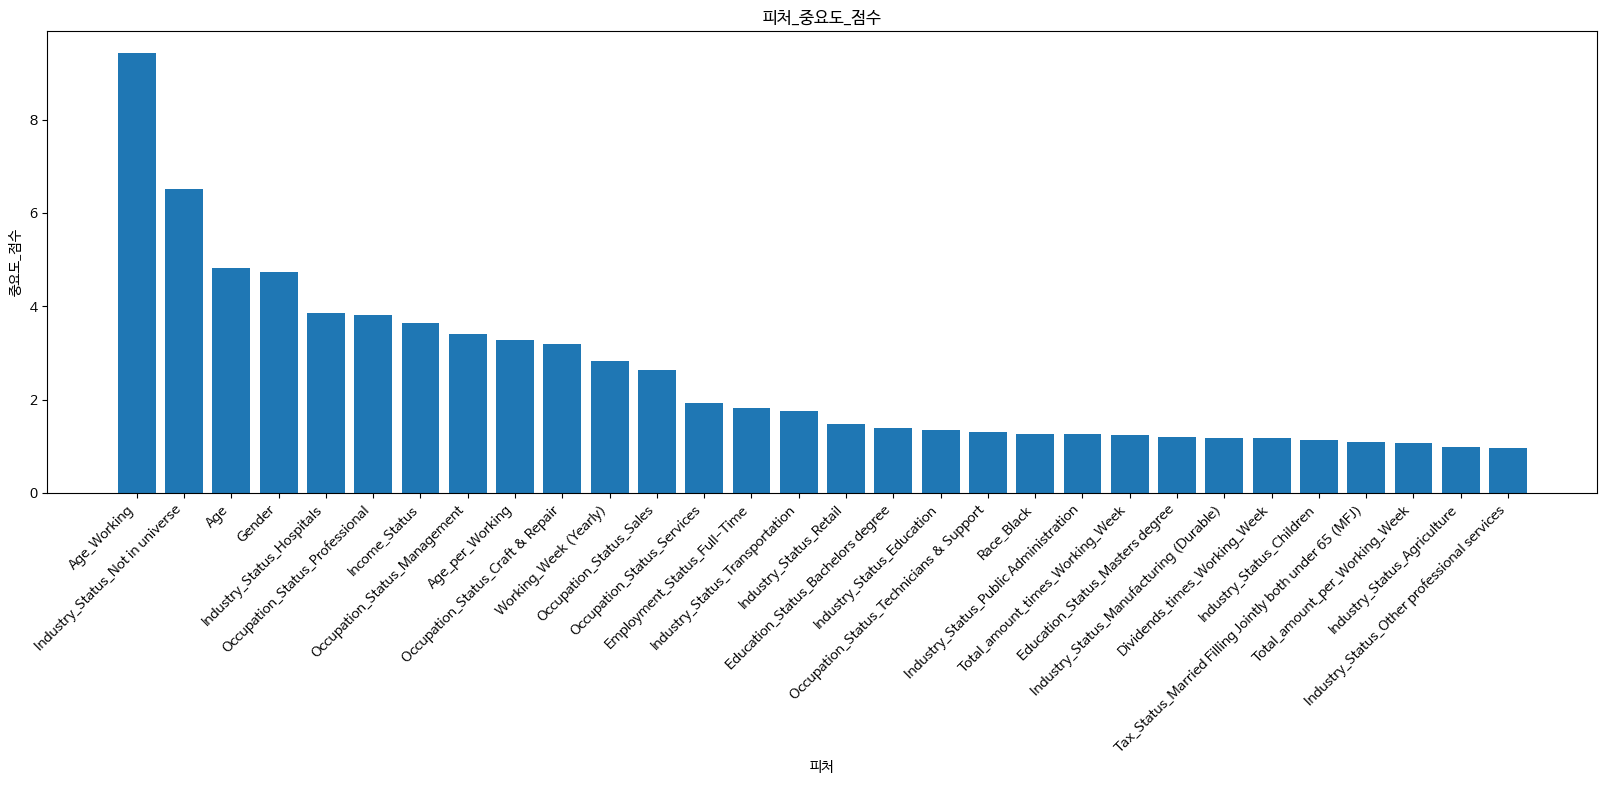

In [ ]:
# 특성 중요도를 기준으로 정렬된 인덱스 가져오기
sorted_indices = feature_importance.argsort()[::-1][:30]

# 정렬된 인덱스를 사용하여 선택된 특성 추출
selected_features = train_ft.columns[sorted_indices]

# 특성 중요도 시각화
plt.figure(figsize=(20, 6))
plt.bar(range(len(selected_features)), feature_importance[sorted_indices], tick_label=selected_features)
plt.title('피처_중요도_점수')
plt.xlabel('피처')
plt.ylabel('중요도_점수')
plt.xticks(rotation=45, ha='right')
plt.show()